# Monetary Policy and Price Dynamics in Japan

In [1]:
# Importing Necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

## Step 1 : Data importing & Initial Observations

In [2]:
df = pd.read_excel(r"D:\9. Self Projects\4. Econometrics Project\Economy of a Country\Original Datasets\Merged data.xlsx")
df.head()

,Year,Quarter_No,Policy Rate,Unemoployment Rate,CPI Rate,Inflation,Consumption,GDP_Bn
0,2000,1,0.036667,5.000000,99.024350,NaN,89.183528,479990.3
1,2000,2,0.026667,4.900000,99.261903,0.239894,89.598113,482123.9
2,2000,3,0.183333,4.866667,99.024350,-0.239320,89.625079,482261.0
3,2000,4,0.236667,4.966667,98.888603,-0.137084,90.489707,486917.4
4,2001,1,0.210000,4.933333,98.617120,-0.274535,91.170087,490540.7


In [3]:
df.dtypes

Year                    int64
Quarter_No              int64
Policy Rate           float64
Unemoployment Rate    float64
CPI Rate              float64
Inflation             float64
Consumption           float64
GDP_Bn                float64
dtype: object

In [4]:
df.isnull().sum()

Year                  0
Quarter_No            0
Policy Rate           0
Unemoployment Rate    0
CPI Rate              0
Inflation             1
Consumption           7
GDP_Bn                0
dtype: int64

In [5]:
df.nunique()

Year                   26
Quarter_No              4
Policy Rate            90
Unemoployment Rate     73
CPI Rate               88
Inflation              99
Consumption            95
GDP_Bn                102
dtype: int64

In [6]:
df.duplicated().sum()

0

## Step 2 : Data Pre-processing

In [7]:
# Converting to a proper Date column for Time Series Analysis
df['Date'] = pd.PeriodIndex(year=df.Year, quarter=df.Quarter_No).to_timestamp()


In [8]:
# Dropping the Extra year columns now
df = df.drop(['Year'], axis=1)


In [9]:
# Setting date column as Index column
df = df.set_index('Date')


array([[<Axes: title={'center': 'Inflation'}>]], dtype=object)

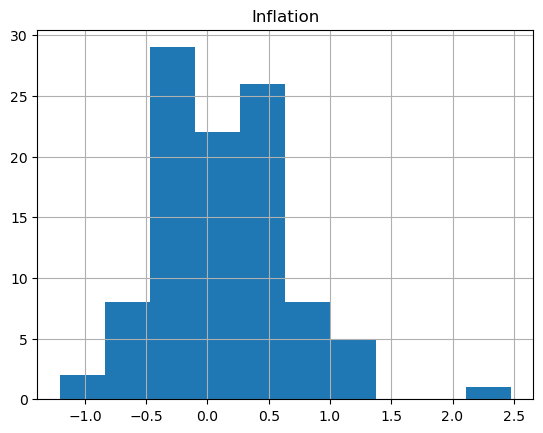

In [10]:
# Checking Histogram for imputation
df[['Inflation']].hist()


In [11]:
# As data is skewed using meadian for imputation
df['Inflation'].fillna(df['Inflation'].median(), inplace=True)
# Also can drop that row as only one row has nan value, but I wanted to keep all quarters.
# df = df.dropna()   it can be use 

## Step 3 : Exploratory Data Analysis

In [12]:
# Univariate Analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quarter_No,102.0,2.480392,1.123382,1.000000,1.250000,2.000000,3.000000,4.000000
Policy Rate,102.0,0.074075,0.162036,-0.073667,-0.030500,0.020167,0.086583,0.563000
Unemoployment Rate,102.0,3.978328,1.050267,2.366667,2.900000,4.100000,4.895994,5.700000
CPI Rate,102.0,99.656400,3.579470,95.834397,97.157887,98.668025,101.179233,112.000000
Inflation,102.0,0.122562,0.538123,-1.203160,-0.239014,0.034889,0.454508,2.476466
Consumption,95.0,96.978142,4.439304,89.183045,93.518906,97.383480,100.701474,104.508018
GDP_Bn,102.0,524253.169608,24727.527453,479889.300000,504164.025000,526651.150000,545384.825000,562987.800000


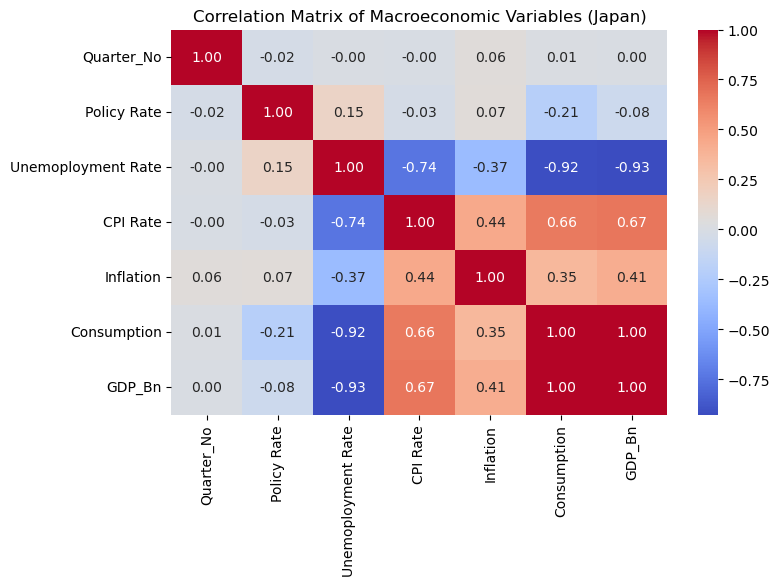

In [13]:
# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Macroeconomic Variables (Japan)")
plt.show()

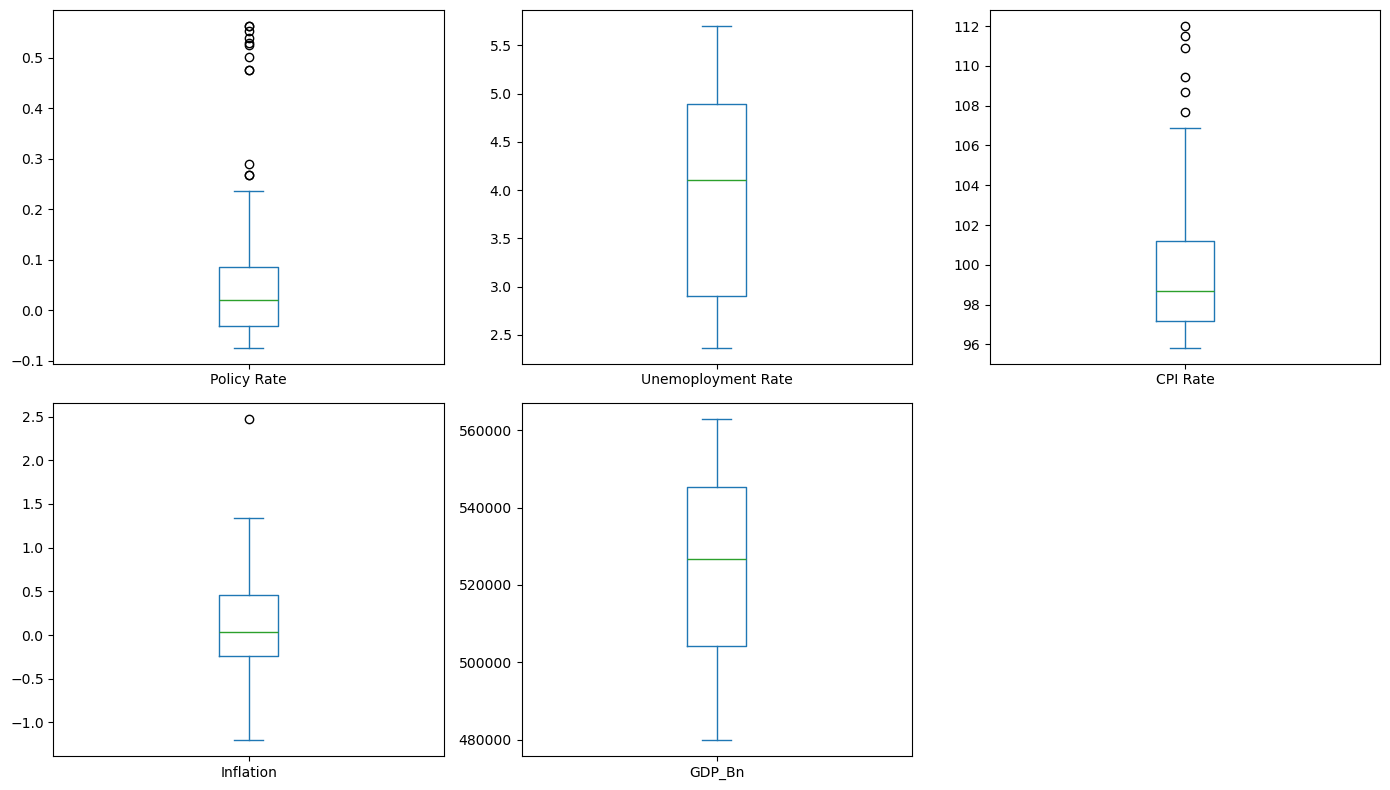

In [14]:
# Checking for outliers using Boxplot
df[['Policy Rate', 'Unemoployment Rate', 'CPI Rate',
       'Inflation', 'GDP_Bn']].plot( kind='box', figsize=(14, 8),
    subplots=True, layout=(2, 3))

plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

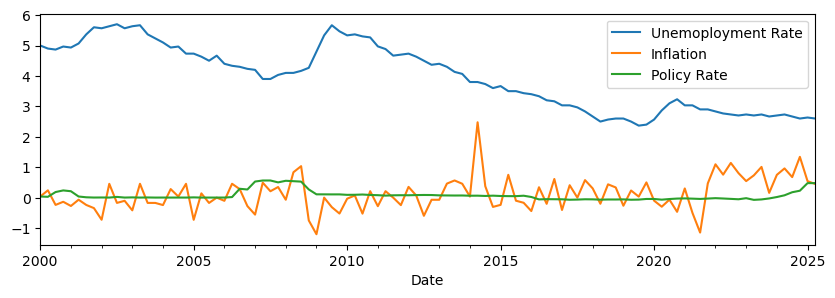

In [15]:
# Time-series Plots
df[['Unemoployment Rate', 'Inflation', 'Policy Rate']].plot(figsize=(10,3))

# Here did not give X value as earlier I set Year as index. So by default it consider index as X and for Y putted the variables

<Axes: xlabel='Date'>

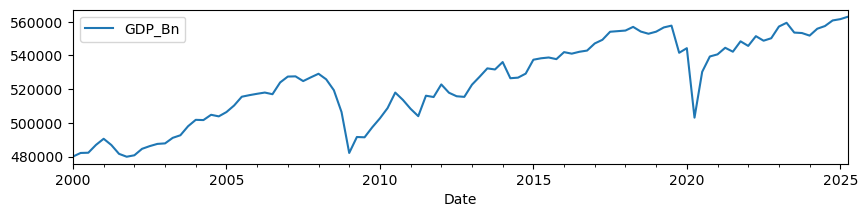

In [16]:
df[['GDP_Bn']].plot(figsize=(10,2))

## Step 4 : Model Preperation

#### 1. Checking Stationary

In [17]:
# Checking Stationary using ADF Test
from statsmodels.tsa.stattools import adfuller

for col in ['Policy Rate', 'Unemoployment Rate',
       'Inflation', 'GDP_Bn']:
    result = adfuller(df[col].dropna())
    print(f"{col}: p-value = {result[1]}")

Policy Rate: p-value = 0.09452731976826373
Unemoployment Rate: p-value = 0.7664503796615856
Inflation: p-value = 0.23265403625322156
GDP_Bn: p-value = 0.48974142788993685


In [18]:
# Doing differencing(In time series analysis, differencing means subtracting the previous observation from the current one)

df_diff = df[['Quarter_No', 'Policy Rate', 'Unemoployment Rate', 'CPI Rate', 'GDP_Bn']].copy()   # Keeping this column as same
df_diff['Inflation'] = df['Inflation'].diff()


In [19]:
for col in ['Inflation']:
    result = adfuller(df_diff[col].dropna())
    print(f"{col}: p-value = {result[1]}")

Inflation: p-value = 3.1082549734669223e-07


#### 2. Creating Lag columns

In [20]:
# Creating Lag columns (A lag column represents the past value of a variable — and we use it because in economics, current outcomes depend on the past)

df_lag = df_diff[['Quarter_No', 'CPI Rate', 'GDP_Bn', 'Inflation']].copy()
df_lag['Policy Rate'] = df_diff['Policy Rate'].shift(1)
df_lag['Unemoployment Rate'] = df_diff['Unemoployment Rate'].shift(1)


In [21]:
# As differencing and lags create nan, so to drop them
df_lag = df_lag.dropna()

#### 3. Regression Model (Phillips Curve)

In [22]:

import statsmodels.api as sm

X = sm.add_constant(df_lag[['Unemoployment Rate', 'Policy Rate']])
y = df_lag['Inflation']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                   0.09592
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.909
Time:                        18:11:34   Log-Likelihood:                -101.10
No. Observations:                 101   AIC:                             208.2
Df Residuals:                      98   BIC:                             216.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0298      0

#### 4. Visualizations

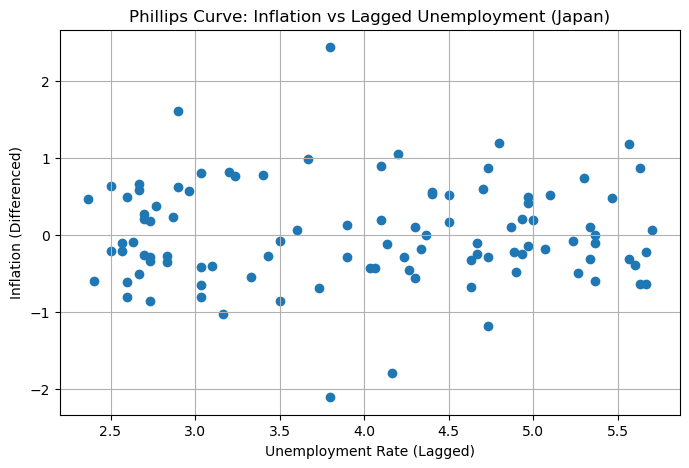

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df_lag['Unemoployment Rate'], df_lag['Inflation'])
plt.xlabel('Unemployment Rate (Lagged)')
plt.ylabel('Inflation (Differenced)')
plt.title('Phillips Curve: Inflation vs Lagged Unemployment (Japan)')
plt.grid(True)
plt.show()


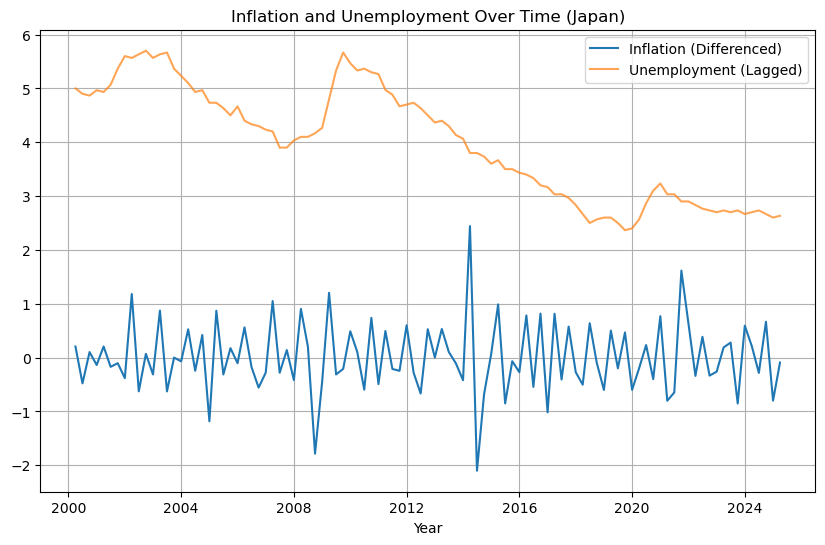

In [24]:
plt.figure(figsize=(10,6))
plt.plot(df_lag.index, df_lag['Inflation'], label='Inflation (Differenced)')
plt.plot(df_lag.index, df_lag['Unemoployment Rate'], label='Unemployment (Lagged)', alpha=0.7)
plt.xlabel('Year')
plt.title('Inflation and Unemployment Over Time (Japan)')
plt.legend()
plt.grid(True)
plt.show()
